<a href="https://colab.research.google.com/github/anilozdemir/Bee-DCD/blob/main/notebooks/02_ESN_with_hidden_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Bee-DCD Repo from GitHub
---

In [1]:
!git clone https://github.com/anilozdemir/Bee-DCD.git

fatal: destination path 'Bee-DCD' already exists and is not an empty directory.


## Install `btdm` module

In [2]:
%cd Bee-DCD/src

/content/Bee-DCD/src


In [3]:
!python setup.py develop

running develop
running egg_info
writing BTDM.egg-info/PKG-INFO
writing dependency_links to BTDM.egg-info/dependency_links.txt
writing top-level names to BTDM.egg-info/top_level.txt
writing manifest file 'BTDM.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/BTDM.egg-link (link to .)
BTDM 1.0 is already the active version in easy-install.pth

Installed /content/Bee-DCD/src
Processing dependencies for BTDM==1.0
Finished processing dependencies for BTDM==1.0


# Using ESN with Hidde Layers to Match Hummingbird Performance

In [5]:
import pickle
import itertools

import numpy as np
from scipy import stats

import pandas as pd
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed

from btdm.networks import ESN_Reservoir, softMax, NoiseLayer
from btdm.environments import DCD_ESN_SingleStep, DCD
from btdm.agents import DCD_Agent
from btdm.utils import rolling_sum

import torch

import matplotlib.pyplot as P
from matplotlib import style
import seaborn as sns
style.use('ggplot')
sns.set_context('talk',font_scale=1.4)
sns.set_style("ticks")

# Get the experiment Data

In [6]:
bb_mean = np.load('../notebooks/data/experiment-data.npz')['bb_mean']
bb_sem  = np.load('../notebooks/data/experiment-data.npz')['bb_sem']
hb_mean = np.load('../notebooks/data/experiment-data.npz')['hb_mean']
hb_sem  = np.load('../notebooks/data/experiment-data.npz')['hb_sem']

h_mean = [0.4, 0.48, 0.54, 0.5025, 0.4388889, 0.475, 0.5805556, 0.5714286, 0.5673469, 0.5095238, 0.56, 0.64, 0.65, 0.6, 0.6535714, 0.6666667]
h_sem  = [0.0942809, 0.08, 0.07333333, 0.06196437, 0.08579692, 0.07511895, 0.05087419, 0.06761234, 0.08498556, 0.05949904, 0.02828427, 0.02828427, 0.09486833, 0.10327956, 0.05787070, 0]

In [7]:
def plot(perf, perf_hb):
    mean    = np.mean(perf, axis=0)
    sem     = stats.sem(perf, axis=0)
    mean_hb = np.mean(perf_hb, axis=0)
    sem_hb  = stats.sem(perf_hb, axis=0) 
    
    nBins = len(mean)
    P.figure(figsize=(14,6))
    P.errorbar(range(len(hb_mean)), hb_mean, yerr = hb_sem, c='gold', lw=3, marker='o', ms=4, mew=5)
    P.errorbar(range(nBins), h_mean, yerr = h_sem, c='fuchsia', lw=3, marker='o', ms=4, mew=5)
    P.errorbar(range(nBins), mean  , yerr = sem  , c='blue'   , lw=3, marker='o', ms=4, mew=5)
    P.errorbar(range(len(hb_mean)), mean_hb  , yerr = sem_hb  , c='green'   , lw=3, marker='o', ms=4, mew=5)
    P.legend(['honeybee','hummingbird', 'ESN', 'ESN_HB'],loc=4)    
    P.plot(range(nBins),[0.5]*nBins,ls='--',c='gray')
    P.xlim(-0.25,nBins-0.75)
    P.xticks(range(nBins), range(1,nBins+1));
    
    P.ylim(0.20,0.85)
    P.yticks(np.linspace(0.25,0.75,3));
    P.xlabel('bins')
    P.ylabel('performance')
    sns.despine(top=True, right=True)

# Optimise Model

In [8]:
env_dcd         = DCD() # env to get hiddenStates
env_fn          = DCD_ESN_SingleStep # env to use hiddenStates

nAgents         = 20

nHiddenLayer    = 2
hiddenLayerSize = 20
noise           = 0.05
lR              = 0.09
quantile        = 0.9
temp            = 1 
contexts        = np.array([[0.5,0], [0,0.5]])
env_dcd         = DCD(contexts=contexts) # env to get hiddenStates
env_fn          = DCD_ESN_SingleStep # env to use hiddenStates

def runAgentParallel(rand):        
    # create a new ESN model
    model = ESN_Reservoir(env_dcd.observation_space.shape[0], env_dcd.action_space.n, nReservoir=1000, activation=torch.tanh, device='cpu', randomSeed = rand)
    # create a new DCD agent
    agent = DCD_Agent(env_dcd, env_fn, model,randomSeed = rand, contexts=contexts)
    # init agent (readout, threshold, optim, noise)
    agent.init_readout_threshold_optim(lR=lR, quantile=quantile, noise=noise, nHiddenLayer = nHiddenLayer, hiddenLayerSize = hiddenLayerSize, temp=temp, SPARCE=True, thrGrad=False)
    # train agent
    agent.train(nEpoch=80, silent=True)
    # evaluate agent
    agent.evaluate(nTrial=10, silent=True)
    # return results 
    return {'train': agent.df, 'test': agent.eval_df}
EXP = Parallel(n_jobs=min(20,nAgents),verbose=0)(delayed(runAgentParallel)(r) for r in range(nAgents))
OverallPerf = np.array([EXP[i]['train'].perf.to_numpy().reshape(-1,5).mean(axis=1) for i in range(nAgents)])

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


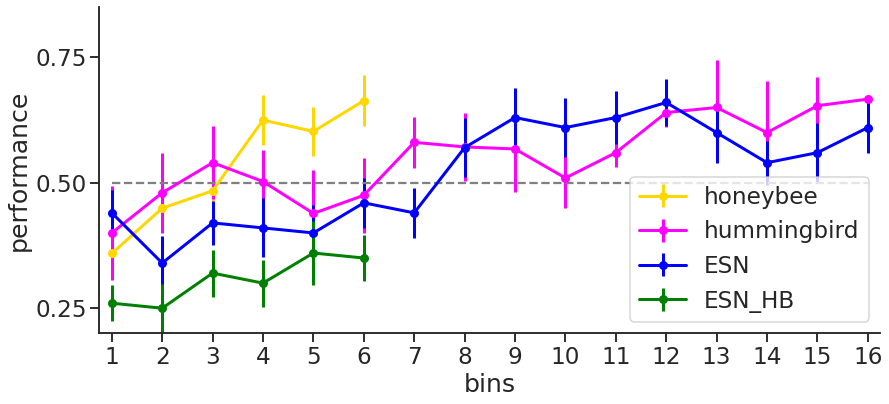

In [9]:
lR_HB = 0.02
def runAgentParallel_HB(rand):        
    # create a new ESN model
    model = ESN_Reservoir(env_dcd.observation_space.shape[0], env_dcd.action_space.n, nReservoir=1000, activation=torch.tanh, device='cpu', randomSeed = rand)
    # create a new DCD agent
    agent = DCD_Agent(env_dcd, env_fn, model, randomSeed = rand, contexts=contexts)
    # init agent (readout, threshold, optim, noise)
    agent.init_readout_threshold_optim(lR=lR_HB, quantile=quantile, noise=noise, nHiddenLayer = nHiddenLayer, hiddenLayerSize = hiddenLayerSize, temp=temp, SPARCE=True, thrGrad=False)
    # train agent
    agent.train(nEpoch=30, silent=True)
    # evaluate agent
    agent.evaluate(nTrial=10, silent=True)
    # return results 
    return {'train': agent.df, 'test': agent.eval_df}
EXP_HB = Parallel(n_jobs=min(50,nAgents),verbose=0)(delayed(runAgentParallel_HB)(r) for r in range(nAgents))
OverallPerf_HB = np.array([EXP_HB[i]['train'].perf.to_numpy().reshape(-1,5).mean(axis=1) for i in range(nAgents)])


plot(OverallPerf, OverallPerf_HB)

# Proving that ESN+HiddenLayer cannot be better than HoneyBee performance

In [10]:
nAgents = 20
LRs = np.hstack([np.arange(0.001,0.01,0.001), np.arange(0.01,0.1,0.01), np.arange(0.1,1,0.1)])
PERF = np.zeros((len(LRs), nAgents, 6)) # there are 6 bins

for i,lR_HB in enumerate(tqdm(LRs)):
    def runAgentParallel_HB(rand):        
        # create a new ESN model
        model = ESN_Reservoir(env_dcd.observation_space.shape[0], env_dcd.action_space.n, nReservoir=1000, activation=torch.tanh, device='cpu', randomSeed = rand)
        # create a new DCD agent
        agent = DCD_Agent(env_dcd, env_fn, model, randomSeed = rand, contexts=contexts)
        # init agent (readout, threshold, optim, noise)
        agent.init_readout_threshold_optim(lR=lR_HB, quantile=quantile, noise=noise, nHiddenLayer = nHiddenLayer, hiddenLayerSize = hiddenLayerSize, temp=temp, SPARCE=True, thrGrad=False)
        # train agent
        agent.train(nEpoch=30, silent=True)
        # evaluate agent
        agent.evaluate(nTrial=10, silent=True)
        # return results 
        return {'train': agent.df, 'test': agent.eval_df}
    EXP_HB = Parallel(n_jobs=min(50,nAgents),verbose=0)(delayed(runAgentParallel_HB)(r) for r in range(nAgents))
    PERF[i] = np.array([EXP_HB[i]['train'].perf.to_numpy().reshape(-1,5).mean(axis=1) for i in range(nAgents)])

  0%|          | 0/27 [00:00<?, ?it/s]